In [40]:
import torch
from pettingzoo.mpe import simple_reference_v3,simple_v3
import numpy as np
from IPython.display import clear_output
from IPython.core.debugger import set_trace
import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
max_frames = 5000000
batch_size = 5
learning_rate = 7e-4
gamma = 0.99
entropy_coef = 0.01
critic_coef = 0.5
no_of_workers = 16

In [42]:
FloatTensor = torch.FloatTensor
LongTensor = torch.LongTensor
environment = simple_reference_v3

In [43]:
class Model(torch.nn.Module):
    def __init__(self, observation_space, action_space):
        super(Model, self).__init__()
        self.features = torch.nn.Sequential(
            torch.nn.Linear(observation_space, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 128),
            torch.nn.ReLU()
        )

        self.critic = torch.nn.Sequential(
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 1)
        )

        self.actor = torch.nn.Sequential(
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, action_space),
            torch.nn.Softmax(dim=-1)
        )
    
    def forward(self, x):
        x = self.features(x)
        value = self.critic(x)
        actions = self.actor(x)
        return value, actions

    def get_critic(self, x):
        x = self.features(x)
        return self.critic(x)
    
    def evaluate_action(self, state, action):
        value, actor_features = self.forward(state)
        dist = torch.distributions.Categorical(actor_features)
        log_probs = dist.log_prob(action).view(-1, 1)
        entropy = dist.entropy().mean()

        return value, log_probs, entropy
    
    def act(self, state):
        value, actor_features = self.forward(state)
        dist = torch.distributions.Categorical(actor_features)

        chosen_action = dist.sample()
        return chosen_action.item()

In [44]:
class Memory(object):
    def __init__(self):
        self.states, self.actions, self.true_values = [], [], []
    
    def push(self, state, action, true_value):
        self.states.append(state)
        self.actions.append(action)
        self.true_values.append(true_value)
    
    def pop_all(self):
        states = torch.stack(self.states)
        actions = LongTensor(self.actions)
        true_values = FloatTensor(self.true_values).unsqueeze(1)

        self.states, self.actions, self.true_values = [], [], []
        return states, actions, true_values

In [64]:
class Worker(object):
    def __init__(self):
        self.env = environment.parallel_env()
        self.episode_rewards = {}
        for agent in self.env.possible_agents:
            self.episode_rewards[agent] = 0
        self.state = self.env.reset()[0]

    def get_batch(self):
        states, actions, rewards, dones = {}, {}, {}, {}
        for agent in self.env.possible_agents:
            states[agent] = []
            actions[agent] = []
            rewards[agent] = []
            dones[agent] = []
        for _ in range(batch_size):
            actiondict = {}
            for agent in self.env.agents:
                mystate = FloatTensor(self.state[agent])
                action = models[agent].act(mystate.unsqueeze(0))
                actiondict[agent] = action
            next_state, reward, terminations, truncations, _ = self.env.step(actiondict)
            for agent in actiondict:
                mystate = FloatTensor(self.state[agent])
                self.episode_rewards[agent] += reward[agent]
                states[agent].append(mystate)
                actions[agent].append(actiondict[agent])
                rewards[agent].append(reward[agent])
                done = False if agent in self.env.agents else True
                dones[agent].append(done)
    
            if not self.env.agents:
                self.state = self.env.reset()[0]
                for agent in self.episode_rewards:
                    data[agent]['episode_rewards'].append(self.episode_rewards[agent])
                    self.episode_rewards[agent] = 0
            else:
                self.state = next_state
        values = {}
        for agent in states:
            values[agent] = compute_true_values(states[agent], rewards[agent], dones[agent], agent).unsqueeze(1)
        return states, actions, values

In [71]:
def compute_true_values(states, rewards, dones, agent):
    true_values = []
    rewards = FloatTensor(rewards)
    dones = FloatTensor(dones)
    states = torch.stack(states)

    if dones[-1] == True:
        next_value = rewards[-1]
    else:
        next_value = models[agent].get_critic(states[-1].unsqueeze(0))

    true_values.append(next_value)
    for i in reversed(range(0, len(rewards) -1)):
        if not dones[i]:
            next_value = rewards[i] + next_value * gamma
        else:
            next_value = rewards[i]
        true_values.append(next_value)
    true_values.reverse()
    return FloatTensor(true_values)

def reflect(memory, agent):
    states, actions, true_values = memory.pop_all()
    values, log_probs, entropy = models[agent].evaluate_action(states, actions)
    advantages = true_values - values
    critic_loss = advantages.pow(2).mean()
    actor_loss = -(log_probs * advantages.detach()).mean()
    total_loss = (critic_coef * critic_loss) + actor_loss - (entropy_coef * entropy)
    optimizers[agent].zero_grad()
    total_loss.backward()
    torch.nn.utils.clip_grad_norm_(models[agent].parameters(), 0.5)
    optimizers[agent].step()
    return values.mean().item()

def plot(data, frame_idx):
    clear_output(True)
    plt.figure(figsize=(20, 5))
    #if data['episode_rewards']:
    ax = plt.subplot(121)
    ax = plt.gca()
    plt.title(f"Frame: {frame_idx}")
    plt.grid()
    for agent in data:
        average_score = np.mean(data[agent]['episode_rewards'][-100:])
        plt.plot(data[agent]['episode_rewards'], label=f"{agent} Avg: {average_score}")
    plt.legend()
    #if data['values']:
    ax = plt.subplot(122)
    plt.title(f"Frame: {frame_idx}")
    for agent in data:
        average_value = np.mean(data[agent]['values'][-1000:])
        plt.plot(data[agent]['values'], label=f"{agent} Avg: {average_value}")
    plt.legend()
    plt.show()

In [72]:
env = environment.parallel_env()
models = {}
memories = {}
optimizers = {}
data = {}
for agent in env.possible_agents: 
    models[agent] = Model(env.observation_space(agent).shape[0], env.action_space(agent).n)
    optimizers[agent] = torch.optim.RMSprop(models[agent].parameters(), lr=learning_rate, eps=1e-5)
    memories[agent] = Memory()
    data[agent] = {
        'episode_rewards': [],
        'values': []
    }
workers = []
for _ in range(no_of_workers):
    workers.append(Worker())
frame_idx = 0

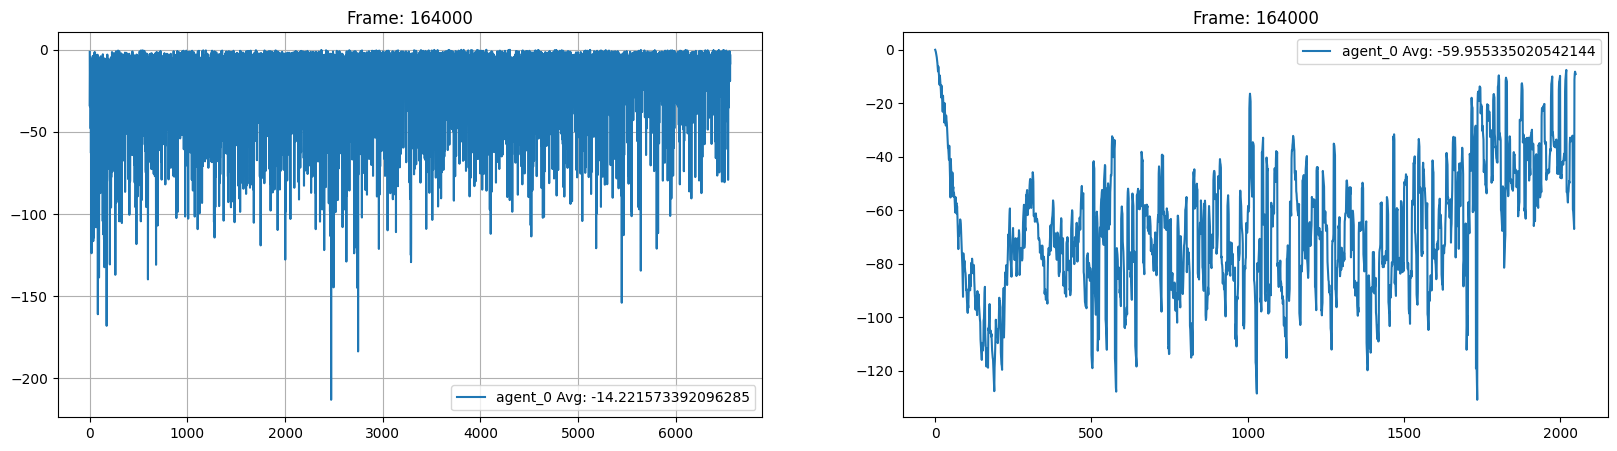

KeyboardInterrupt: 

In [73]:
%debug
#state = FloatTensor(env.reset()[0]["agent_0"])
#episode_reward = 0
while frame_idx < max_frames:
    for worker in workers:
        states, actions, true_values = worker.get_batch()
        for agent in states:
            for i, _ in enumerate(states[agent]):
                memories[agent].push(states[agent][i], actions[agent][i], true_values[agent][i])
        frame_idx += batch_size
    for agent in memories:
        value = reflect(memories[agent], agent)
        data[agent]['values'].append(value)
    if frame_idx % 1000 == 0:
        plot(data, frame_idx)

In [10]:
torch.save(model, "MyModel.pt")

In [15]:
env = simple_v3.parallel_env(render_mode="human")
while True:
    state = FloatTensor(env.reset()[0]["agent_0"])
    while env.agents:
        action = model.act(state.unsqueeze(0))
        actiondict = {}
        actiondict["agent_0"] = action
        next_state, reward, terminations, truncations, _ = env.step(actiondict)
        done = False if "agent_0" in terminations else True

        if done:
            state = FloatTensor(env.reset()[0]["agent_0"])
        else:
            state = FloatTensor(next_state["agent_0"])

KeyboardInterrupt: 

In [11]:
env = simple_v3.parallel_env()
print(env.possible_agents)

['agent_0']
